# Digit Recognition Using Neural Networks



### Importing necessary modules: 



In [43]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

### Loading Training Data : 



In [44]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# Number of training examples
m = y.size

### Visualizing the Data : 



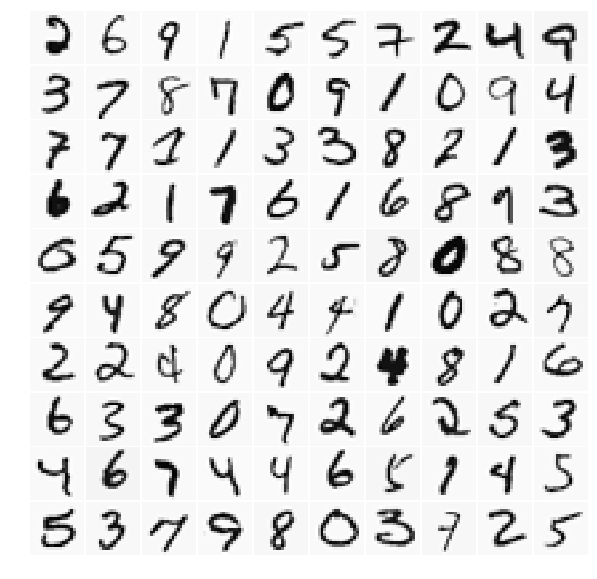

In [45]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

## Model Representation for our Neural Network : 

![](Figures/neural_network.png)



In [46]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.
    
    Parameters
    ----------
    L_in : int
        Number of incomming connections.
    
    L_out : int
        Number of outgoing connections. 
    
    epsilon_init : float, optional
        Range of values which the weight can take from a uniform 
        distribution.
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
        
    Instructions
    ------------
    Initialize W randomly so that we break the symmetry while training
    the neural network. Note that the first column of W corresponds 
    to the parameters for the bias unit.
    """

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in))

    # ====================== YOUR CODE HERE ======================

    W = ((np.random.rand(L_out, 1 + L_in))*2*epsilon_init) - (epsilon_init) 

    # ============================================================
    return W

In [47]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

print('Done Initializing :)')

Initializing Neural Network Parameters ...
Done Initializing :)


In [48]:
def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z. 
    This should work regardless if z is a matrix or a vector. 
    In particular, if z is a vector or matrix, you should return
    the gradient for each element.
    
    Parameters
    ----------
    z : array_like
        A vector or matrix as input to the sigmoid function. 
    
    Returns
    --------
    g : array_like
        Gradient of the sigmoid function. Has the same shape as z. 
    
    Instructions
    ------------
    Compute the gradient of the sigmoid function evaluated at
    each value of z (z can be a matrix, vector or scalar).
    
    Note
    ----
    We have provided an implementation of the sigmoid function 
    in `utils.py` file accompanying this assignment.
    """

    g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================

    g = (utils.sigmoid(z))*(1 - utils.sigmoid(z))

    # =============================================================
    return g

## Calculating Cost using Backpropagation : 

![](Figures/ex4-backpropagation.png)



In [49]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    
    Instructions
    ------------
    You should complete the code by working through the following parts.
    
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    
    - Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. After implementing Part 2, you can check
              that your implementation is correct by running checkNNGradients provided
              in the utils.py module.
    
              Note: The vector y passed into the function is a vector of labels
                    containing values from 0..K-1. You need to map this vector into a 
                    binary vector of 1's and 0's to be used with the neural network
                    cost function.
     
              Hint: We recommend implementing backpropagation using a for-loop
                    over the training examples if you are implementing it for the 
                    first time.
    
    - Part 3: Implement regularization with the cost function and gradients.
    
              Hint: You can implement this around the code for
                    backpropagation. That is, you can compute the gradients for
                    the regularization separately and then add them to Theta1_grad
                    and Theta2_grad from Part 2.
    
    Note 
    ----
    We have provided an implementation for the sigmoid function in the file 
    `utils.py` accompanying this assignment.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== YOUR CODE HERE ======================
    X_pred = np.concatenate([np.ones((m, 1)), X], axis=1)
    A = utils.sigmoid(np.dot(X_pred, Theta1.T))
    A = np.concatenate([np.ones((m, 1)), A], axis=1)
    hypothesis = utils.sigmoid(np.dot(A, Theta2.T))
    total = 0 
    
    for i in range(m):
        for k in range(num_labels):
            if k == y[i]:
                total += (-np.log(hypothesis[i][k]))
            else:
                total += (-np.log(1 - hypothesis[i][k]))
    
    J = total/m
    J += (lambda_/(2*m))*(np.sum(((Theta1.T[1:])*(Theta1.T[1:]))) + np.sum(((Theta2.T[1:])*(Theta2.T[1:]))))
    
    Delta_1 = np.zeros(Theta1.shape)
    Delta_2 = np.zeros(Theta2.shape)
    
    for t in range(m):
        a_1 = X_pred[t]
        z_2 = np.dot(Theta1, a_1)
        a_2 = utils.sigmoid(z_2)
        a_2 = np.concatenate([np.ones(1), a_2])
        z_3 = np.dot(Theta2, a_2)
        a_3 = utils.sigmoid(z_3)
        
        y_vector = np.zeros(num_labels)
        y_vector[y[t]] = 1
        delta_3 = (a_3 - y_vector)
        
        delta_2 = (np.dot(Theta2.T, delta_3))*(np.concatenate([np.zeros(1), sigmoidGradient(z_2)]))
        
        delta_3 = np.array([delta_3])
        a_2 = np.array([a_2])
        Delta_2 += np.dot(delta_3.T, a_2)
        
        delta_2 = delta_2[1:]
        delta_2 = np.array([delta_2])
        a_1 = np.array([a_1])
        Delta_1 += np.dot(delta_2.T, a_1)
        #print(Delta_2[:, 1:]/m)
    
    # ================================================================
    # Unroll gradients
    Theta2_grad[:, 1:] = ((Delta_2[:, 1:])/m) + (((lambda_)/m)*(Theta2[:, 1:]))
    Theta2_grad[:, 0] = (Delta_2[:, 0]/m)
    Theta1_grad[:, 1:] = ((Delta_1[:, 1:])/m) + (((lambda_)/m)*(Theta1[:, 1:]))
    Theta1_grad[:, 0] = (Delta_1[:, 0]/m)
    
    #grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

## Verifying Implementation of Backpropagation : 



In [50]:
#  Check gradients by running checkNNGradients
lambda_ = 3
utils.checkNNGradients(nnCostFunction, lambda_)

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join('Data', 'ex4weights.mat'))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, and the weights given in the Data, this value should be about 0.576051)')

[[-9.27825235e-03 -9.27825236e-03]
 [-1.67679797e-02 -1.67679797e-02]
 [-6.01744725e-02 -6.01744725e-02]
 [-1.73704651e-02 -1.73704651e-02]
 [ 8.89911959e-03  8.89911960e-03]
 [ 3.94334829e-02  3.94334829e-02]
 [-3.19612287e-02 -3.19612287e-02]
 [-5.75658668e-02 -5.75658668e-02]
 [-8.36010761e-03 -8.36010762e-03]
 [ 5.93355565e-02  5.93355565e-02]
 [ 2.49225535e-02  2.49225535e-02]
 [-4.51963845e-02 -4.51963845e-02]
 [ 7.62813551e-03  7.62813551e-03]
 [ 2.47640974e-02  2.47640974e-02]
 [ 5.97717617e-02  5.97717617e-02]
 [ 9.14587966e-03  9.14587966e-03]
 [-6.74798369e-03 -6.74798370e-03]
 [-3.26881426e-02 -3.26881426e-02]
 [ 3.86410548e-02  3.86410548e-02]
 [ 5.46101548e-02  5.46101547e-02]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.18682669e-01  1.18682669e-01]
 [ 2.03987128e-01  2.03987128e-01]
 [ 1.25698067e-01  1.25698067e-01]
 [ 1.76337550e-01  1.76337550e-01]
 [ 1.32294136e-01  1.32294136e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 3.81928666e-05  3.81928696e-05]
 [ 1.17148233e-01  1

## Training the Neural Network : 



In [51]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 100}

#  You should also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [52]:
pred = utils.predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 94.460000


# Visualizing the Results : 



In [53]:
def nnpredict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.
    
    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)
    
    Theta2: array_like
        Weights for the second layer in the neural network. 
        It has shape (output layer size x 2nd hidden layer size)
    
    X : array_like
        The image inputs having shape (number of examples x image dimensions).
    
    Return 
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned neural
    network. You should set p to a vector containing labels 
    between 0 to (num_labels-1).
     
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the  max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index
    of the max for each row.
    
    Note
    ----
    Remember, we have supplied the `sigmoid` function in the `utils.py` file. 
    You can use this function by calling `utils.sigmoid(z)`, where you can 
    replace `z` by the required input variable to sigmoid.
    """
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # useful variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    

    # You need to return the following variables correctly 
    p = np.zeros(X.shape[0])

    # ====================== YOUR CODE HERE ======================
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    A = utils.sigmoid(np.dot(X, Theta1.T))
    A = np.concatenate([np.ones((A.shape[0], 1)), A], axis=1)
    p = np.argmax(utils.sigmoid(np.dot(A, Theta2.T)), axis=1)
    
    # =============================================================
    return p

Neural Network Prediction: 4


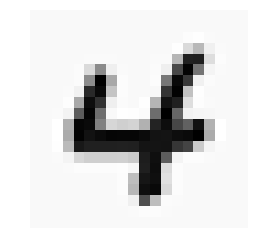

In [59]:
indices = np.random.permutation(m)

if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = nnpredict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')